In [0]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import importlib
from torch.utils.data.sampler import SubsetRandomSampler

from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

In [0]:
!rm -rf CS601R_Final_Project/ models/ datasets/ notebooks/
!git clone https://github.com/webMan1/CS601R_Final_Project.git
!cp -r CS601R_Final_Project/* .

Cloning into 'CS601R_Final_Project'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 99 (delta 49), reused 72 (delta 22), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [0]:
import datasets.EncodedStanfordCarsDataset
import models.CLRDecoder
import importlib

datasets.EncodedStanfordCarsDataset = importlib.reload(datasets.EncodedStanfordCarsDataset)
models.CLRDecoder = importlib.reload(models.CLRDecoder)

CLRDecoder = models.CLRDecoder.CLRDecoder

# Training Loop

In [0]:
def train(model, optimizer, train_loader, valid_loader, num_epochs:int, valid_freq:int=10):
  train_len = len(train_loader)
  valid_len = len(valid_loader)
  loop = tqdm(total=(num_epochs * train_len + (num_epochs // valid_freq) * valid_len), position=0)

  train_losses = []
  train_accs = []

  valid_losses = []
  valid_accs = []

  criteria = nn.CrossEntropyLoss()

  for e in range(num_epochs):
    loss_builder = []
    acc_builder = []

    for i, (x, y_truth) in enumerate(train_loader):
      x, y_truth = x.cuda(async=False), y_truth.long().squeeze(1).cuda(async=False)
      optimizer.zero_grad()
      
      y_hat = model(x)

      total_loss = criteria(y_hat, y_truth)
      total_loss.backward()

      acc = y_truth.eq(y_hat.argmax(1)).sum().item() / len(y_truth)

      optimizer.step()

      loss_builder.append(total_loss.item())
      acc_builder.append(acc)

      loop.update(1)
      loop.set_description(f"Epoch: {e}, it: {i}/{train_len}. Loss: {total_loss.item()}. Acc: {acc}")
    
    train_accs.append(acc_builder)
    train_losses.append(loss_builder)

    if e % valid_freq == 0:
      loss_builder = []
      acc_builder = []

      with torch.no_grad():
        model.eval()

        for i, (x, y_truth) in enumerate(valid_loader):
          x, y_truth = x.cuda(async=False), y_truth.long().squeeze(1).cuda(async=False)

        y_hat = model(x)

        total_loss = criteria(y_hat, y_truth)
        acc = y_truth.eq(y_hat.argmax(1)).sum().item() / len(y_truth)

        loss_builder.append(total_loss.item())
        acc_builder.append(acc)

        loop.update(1)
        loop.set_description(f"[VALIDATING] Epoch: {e}, it: {i}/{valid_len}. Loss: {total_loss.item()}. Acc: {acc}")

      model.train()

      valid_accs.append(acc_builder)
      valid_losses.append(loss_builder)
    
    state = {
        "model": model.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "valid_losses": valid_losses,
        "valid_accs": valid_accs,
        "epoch": e
    }
    num = ((e + 4) // 5) * 5
    path = f"/content/gdrive/My Drive/SimCLR/models/stanford/clr_cross_e_{num}_linear.mod"
    torch.save(state, path)

  return train_losses, train_accs, valid_losses, valid_accs

In [0]:
def run_training():
  batch_size = 64
  model = CLRDecoder(196).cuda()
  optimizer = optim.Adam(model.parameters())

  train_loader = datasets.EncodedStanfordCarsDataset.get_loader(True, batch_size, True)
  valid_loader = datasets.EncodedStanfordCarsDataset.get_loader(False, batch_size, True)

  num_epochs = 71
  
  train_losses, train_accs, valid_losses, valid_accs = train(model, optimizer, train_loader, valid_loader, num_epochs=141, valid_freq=5)

  return train_losses, train_accs, valid_losses, valid_accs

In [0]:
res1 = run_training()

[VALIDATING] Epoch: 140, it: 127/126. Loss: 4.159952640533447. Acc: 0.1875:  84%|████████▍ | 18077/21576 [02:19<00:25, 136.80it/s]

In [0]:
train_losses, train_accs, train_faccs, valid_losses, valid_accs, valid_faccs = res1

# Test Results

In [0]:
def show_res(epoch:int, suffix:str):
  save_loc = f"/content/gdrive/My Drive/SimCLR/models/stanford/clr_e_{epoch}_linear.mod"
  state = torch.load(save_loc)
  
  epoch = state["epoch"]
  
  train_losses, train_accs = state["train_losses"], state["train_accs"]
  valid_losses, valid_accs = state["valid_losses"], state["valid_accs"]

  train_loss_averages = [ np.mean(l) for l in train_losses]
  valid_loss_averages = [ np.mean([i for i in l]) for l in valid_losses]

  train_acc_averages = [ np.mean([i for i in l]) for l in train_accs]
  valid_acc_averages = [ np.mean([i for i in l]) for l in valid_accs]

  print(f"Got to epoch {epoch}")
  plt.title("Cross Entropy Loss")
  plt.plot(train_loss_averages, label="Training")
  plt.plot(range(0, len(train_loss_averages), 5), valid_loss_averages, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc="best")
  plt.show()

  plt.title("Accuracy")
  plt.plot(train_acc_averages, label="Training")
  plt.plot(range(0, len(train_acc_averages), 5), valid_acc_averages, label="Validation")
  plt.xlabel('Epochs')
  plt.ylabel("Accuracy")
  plt.legend(loc="best")
  plt.show()

  return state

Got to epoch 140


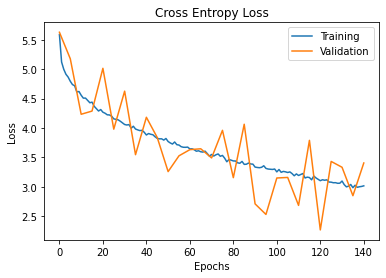

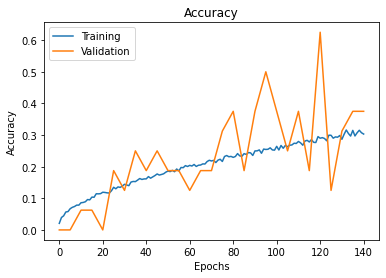

In [0]:
state = show_res(140, "")
# print(state["valid_losses"])
# state2 = show_res(False, 15)

In [0]:
loader = datasets.EncodedStanfordCarsDataset.get_loader(False, 32)

In [0]:
model = CLRDecoder(196, True)
model.load_state_dict(state['model'])

test_its = 1
sigmoid = nn.Sigmoid()

accs = []

class_success = np.array([ 0.0 for _ in range(196) ])
class_counts = np.array([ 0.0 for _ in range(196) ])

for i, (x, y) in zip(range(test_its), loader):
  # import pdb; pdb.set_trace()
  o = model(x)

  y = y.squeeze(1)
  preds = o.argmax(1).int()
  # print(y)
  # print(preds)
  diff = preds.eq(y)

  acc = diff.sum().item() / diff.numel()

  accs.append(acc)
  # print(diff.shape)
  for d, t in zip(diff, y):
    # print(t)
    if d:
      class_success[t] += 1
    class_counts[t] += 1

print(f"Accuracy: {np.average(accs)}")
print(f"Naive acc would be {1 / 196}")

class_accs = class_success / class_counts
class_freqs = class_counts / 196

plt.title("Class Accuracies")
plt.bar(range(len(class_accs)), class_accs)
plt.show()

NameError: ignored

# Find centroids and average for each class.

In [0]:
loader = datasets.EncodedStanfordCarsDataset.get_loader(True, 32)
dataset = loader.dataset
encodings = dataset.encodings


CS601R_Final_Project  datasets	gdrive	models	notebooks  sample_data


In [0]:
first_encoding = encodings[0]
centroid_finders = [ { "sum": torch.zeros(first_encoding.size()), "count": 0 } for _ in range(196) ]

for encoding, label in dataset:
  centroid_finders[label.item()]["sum"] += encoding
  centroid_finders[label.item()]["count"] += 1

centroids = [ c["sum"] / c["count"] for c in centroid_finders ]


In [0]:
def dist(a, b):
  return torch.dist(a, b, 2)

In [0]:
most_averages = [ { "index": -1, "dist": np.inf } for _ in range(196) ]

for i, (encoding, label) in enumerate(dataset):
  idx = label.item()
  centroid = centroids[idx]
  d = dist(centroid, encoding)
  if most_averages[idx]["dist"] > d:
    most_averages[idx]["dist"] = d
    most_averages[idx]["index"] = i

In [0]:
most_averages

In [0]:
centroids_state = {
    "centroids": centroids, "averages": most_averages
}
dist_loc = f"/content/gdrive/My Drive/SimCLR/data/stanfordCars/most_average_cars.mod"
torch.save(centroids_state, dist_loc)

In [0]:
import scipy
m = scipy.io.loadmat("/content/gdrive/My Drive/SimCLR/data/stanfordCars/cars_train_annos.mat")

In [0]:
m

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 'annotations': array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
         ...,
         (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9')),
         (array([[78]], dtype=uint8), array([[526]], dtype=uint16), 